# Chapter 4

<a target="_blank" href="https://colab.research.google.com/github/CausalAILab/causalai-book/blob/main/chapter4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Simpson's Paradox

Consider a medical setting with binary variables where:
- $X = 1$ indicates the patient took a certain drug for a year
- $Y = 1$ indicates that the patient recovered after one year of taking the drug
- $Z = 1$ indicates the patient is female

In [1]:
import os
import sys

if 'google.colab' in sys.modules:
    os.system("wget -O scm.py https://raw.githubusercontent.com/CausalAILab/causality-book/main/scm.py")

print(sys.version)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]


In [2]:
from sympy import symbols, Function, Symbol

from scm import SymbolicSCM

from causal_graph import CausalGraph

## Definition 4.1.1. Interventional Distribution

Given two disjoint sets of variables, $\mathbf X$ and $\mathbf Y$, the causal effect of $\mathbf X$ on $\mathbf Y$, denoted, $P(\mathbf y | do(\mathbf X = \mathbf x))$, is a function from $\mathbf X$ to the space of probability distributions of $\mathbf Y$. For each realization, $\mathbf X = \mathbf x$, $P(\mathbf y | do(\mathbf x))$ gives the probability of $\mathbf Y = \mathbf y$ induced by deleting from the model all equations corresponding to variables in $\mathbf X = \mathbf x$ and substituting $\mathbf X = \mathbf x$ in the remaining equations.

### Example 4.3 - Sprinkler

Consider a classic setting where a robot is in charge of maintaining
the backyard healthy and nourished throughout the entire year. The robot keeps track of the season
($Se$), sprinkler ($Sp$), rain ($Ra$), the wetness of the floor ($We$), and whether it is slippery ($Sl$). The
causal diagram $G$ is shown below and represents the following collection of mechanisms:

$$
\begin{align}
F &= \begin{cases}
    Se &\gets f_{Se}(U_{Se}) \\ 
    Sp &\gets f_{Sp}(Se, U_{Sp}) \\ 
    Ra &\gets f_{Ra}(Se, U_{Ra}) \\ 
    We &\gets f_{We}(Sp, Ra, U_{We}) \\ 
    Sl &\gets f_{Sl}(We, U_{Sl}) \\ 
\end{cases} \\
\end{align}
$$

for some $P(\mathbf U)$.

![Figure 4.6](Fig-4-6.png)

In [3]:
v = se, sp, ra, we, sl = symbols('Se Sp Ra We Sl')
f = f_se, f_sp, f_ra, f_we, f_sl = [Function(f'f_{{{k}}}') for k in v]
u = u_se, u_sp, u_ra, u_we, u_sl = [Symbol(f'u_{{{k}}}') for k in v]

m = SymbolicSCM(
    f={
        se: f_se(u_se),
        sp: f_sp(se, u_sp),
        ra: f_ra(se, u_ra),
        we: f_we(sp, ra, u_we),
        sl: f_sl(we, u_sl),
    },
    pu = {
        u_se: 0.5,
        u_sp: 0.5,
        u_ra: 0.5,
        u_we: 0.5,
        u_sl: 0.5,
    }
)

## Definition 4.2.2 - Back-door Criterion

Let $G$ be a causal diagram and $\mathbf X$ and $\mathbf Y$ be the sets of treatment and outcome variable, respectively. A set of variables $\mathbf Z$ is said to satisfy the back-door criterion (BDC) relative to the pair $(\mathbf X, \mathbf Y)$ in $G$ if:

1. No node in $\mathbf Z$ is a descendant of $\mathbf X$, and 
2. $\mathbf Z$ blocks every path between $\mathbf X$ and $\mathbf Y$ that contains an arrow into $\mathbf X$.

### Theorem 4.2.5 - Conditional Back-door Adjustment

Let $G$ be a causal diagram and $\mathbf X, \mathbf Y, \mathbf W$ be the sets of treatment, outcomes, and covariates variables, respectively. If a set of variables $\mathbf Z \cup \mathbf W$ satisfies the back-door criterion relative to the pair $(\mathbf X, \mathbf Y)$, then the $\mathbf W$-specific effect of $\mathbf X$ on $\mathbf Y$ is identifiable and given by:

\begin{equation}
P(\mathbf y | do(\mathbf x), \mathbf w) = \sum_{\mathbf z} P(\mathbf y | \mathbf x, \mathbf z, \mathbf w) P(\mathbf z | \mathbf w)
\end{equation}

In [4]:
x1, x2, y, z1, z2, z3, z4 = symbols('X1 X2 Y Z1 Z2 Z3 Z4')

fig_4_14 = CausalGraph(
    v=[x1, x2, y, z1, z2, z3, z4],
    directed_edges=[
        (x1, z1),
        (z1, z2),
        (z2, z3),
        (z3, x2),
        (x2, y),
        (x1, y),
        (x1,z4),
        (y,z4)
    ],
    bidirected_edges=[
        (z2,y),
        (z3,y)
    ]
)

In [5]:
x1, x2, y, z1, z2, z3 = symbols('X1 X2 Y Z1 Z2 Z3')

fig_4_14 = CausalGraph(
    v=[x1, x2, y, z1, z2, z3],
    directed_edges=[
        (x1, z1),
        (z1, z2),
        (z2, z3),
        (z3, x2),
        (x2, y),
        (x1, y),
    ],
    bidirected_edges=[
        (z2,y),
        (z3,y)
    ]
)

In [6]:
fig_4_14.is_backdoor_adjustment(x={x1, x2}, y=y, z={z1, z2, z3})

True

In [7]:
fig_4_14.find_backdoor_adjustment(x={x1, x2}, y=y, included={x1,x2})

[Z1, Z3]

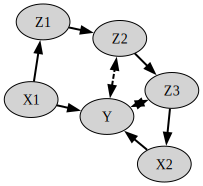

In [8]:
fig_4_14.draw()

In [9]:
fig_4_14.find_backdoor_adjustment(x={x1, x2}, y=y)

[Z1, Z3]

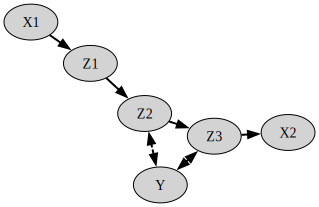

In [10]:
fig_4_14.get_adjustment_backdoor_graph(
    x={x1, x2},
    y=y
).draw()

In [11]:
x, z, y, w1, w2, w3 = symbols('X Z Y W1 W2 W3')

fig_4_24 = CausalGraph(
    v=[x, z, y, w1, w2, w3],
    directed_edges=[
        (x, z),
        (z, y),
        (w1, y),
        (w1,x),
        (w2, x),
        (w2, z),
        (w3, z),
        (w3, y)
    ],
    bidirected_edges=[
        (x,y)
    ]
)

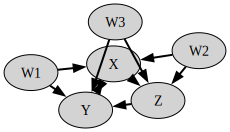

In [12]:
fig_4_24.draw()

In [13]:
fig_4_24.is_frontdoor_adjustment(
    x=x,
    y=y,
    z=z,
    xz={w2},
    zy={w3}
)

True

In [14]:
fig_4_24.find_frontdoor_adjustment(x={x}, y=y)

([Z], [W2], [W3])

In [15]:
fig_4_24.find_all_frontdoor_adjustments(x={x}, y=y)

[([Z], [W2], [W3]), ([Z], [W2], [W3, W1]), ([Z], [W2, W1], [W3])]